# Run Sequential Monte Carlo Method

In [109]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from functions_sir import *
plt.rcParams['figure.figsize'] = (12,8)

In [123]:
# now set up and run sir algorithm

NUM_SAMP = 500
SIM_LENGTH = 100

# initialise with state samples uniformly distributed on interval +/-25
xinit = 50*(sorteduniform(NUM_SAMP)-0.5)
winit = 1/NUM_SAMP # and weights uniformly distributed
winit = winit*np.ones((NUM_SAMP,1))

# now run the SIR algorithm
xdata, zdata = gen_data(NUM_SAMP, SIM_LENGTH)
#plt.plot(xdata[0:100])
#plt.plot(zdata[0:100])

xtrack, wtrack, xintermed, z_pred = sir(xinit, winit, zdata)

# make plot
xstime, pxsdata, xsmean, xsintermed, zspred = create_plot_data(
    SIM_LENGTH, NUM_SAMP, xtrack, xintermed, z_pred)
time = np.arange(0,SIM_LENGTH,1)


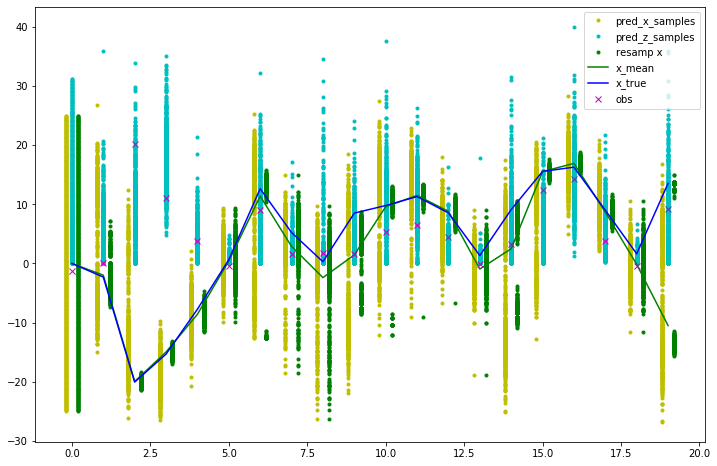

In [124]:
min_i = 0
max_i = 20

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xstime[(xstime<max_i) & (xstime >= min_i)]-.2, xsintermed[(xstime<max_i) & (xstime >= min_i)], 
        'y.',label='pred_x_samples')
ax.plot(xstime[(xstime<max_i) & (xstime >= min_i)], zspred[(xstime<max_i) & (xstime >= min_i)], 
        'c.',label='pred_z_samples')
ax.plot(xstime[(xstime<max_i) & (xstime >= min_i)] + .2, pxsdata[(xstime<max_i) & (xstime >= min_i)], 
        'g.', label='resamp x')
ax.plot(time[min_i:max_i], xsmean[0, min_i:max_i], 'g', label='x_mean')
ax.plot(time[min_i:max_i], xdata[min_i:max_i,0], 'b', label='x_true')
ax.plot(time[min_i:max_i], zdata[min_i:max_i,0], 'mx', label='obs')
ax.legend()
plt.show()

### Drill down into some details

The 'true' x values were generated from a cyclical cosine function, plus some gaussian noise and a nonlinear amplification of the magnitude.
Observations are created with the obs. formula f(x) = (x*x)/20 + N(0,1)


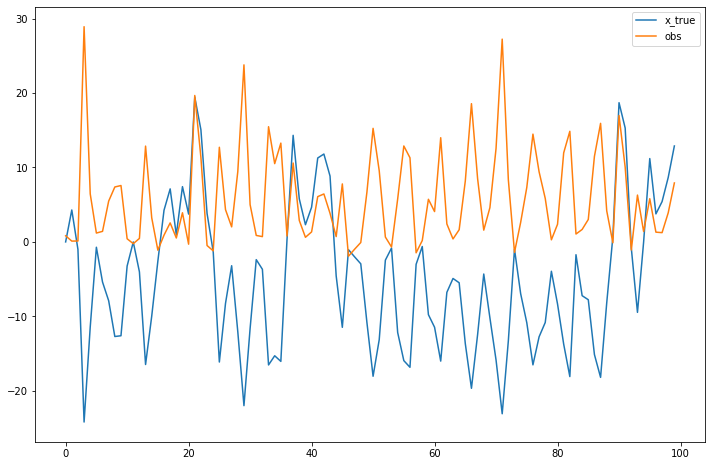

In [31]:
plt.plot(xdata, label='x_true')
plt.plot(zdata, label='obs')
plt.legend()

Process:
1. Calculate uniformly distributed set of 500 samples (*xinit*)
2. Calculate initial weights for each of the 500 samples - start with equal weights of 1/nsamples
3. Transition all of the 500 *xinit* samples to the next time step, by putting them through the  
transition function: *nonlinear amplification(x_t-1) + cosine(f(time)) + gaussian noise*
4. Calculate the liklihood from these new 500 *x* points, with the prev. timestep weights, against the current observation:
vector of errors, err = observed value, z, - f(vector of x's)  
where f(x) = x^2/20  
updated weights = (exp(-err^2)/2 ).w  
So, the updated weights become exponentially smaller, the higher the error. This means that the x values that give f(x) closest to z have much higher weights within the same time step.
5. If the effective number of samples (based on weights) is less than half of the actual number of samples, perform resampling. This creates more x samples where the weights are higher, and then resets all the weights of these resampled x samples to be equal (1/nsamples). There are still nsamples number of x samples.  
These resampled x's become the new set of x samples for that same time step. And the equal weights are the new set of weights for that time step.


Note some patterns in this plot below:

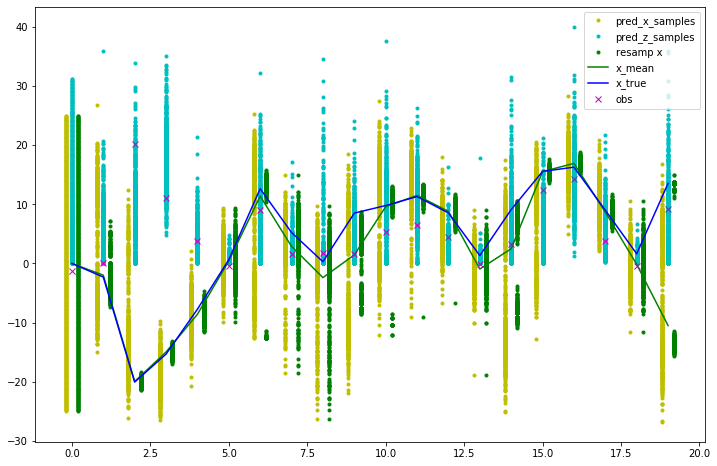

In [126]:
min_i = 0
max_i = 20

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xstime[(xstime<max_i) & (xstime >= min_i)]-.2, xsintermed[(xstime<max_i) & (xstime >= min_i)], 
        'y.',label='pred_x_samples')
ax.plot(xstime[(xstime<max_i) & (xstime >= min_i)], zspred[(xstime<max_i) & (xstime >= min_i)], 
        'c.',label='pred_z_samples')
ax.plot(xstime[(xstime<max_i) & (xstime >= min_i)] + .2, pxsdata[(xstime<max_i) & (xstime >= min_i)], 
        'g.', label='resamp x')
ax.plot(time[min_i:max_i], xsmean[0, min_i:max_i], 'g', label='x_mean')
ax.plot(time[min_i:max_i], xdata[min_i:max_i,0], 'b', label='x_true')
ax.plot(time[min_i:max_i], zdata[min_i:max_i,0], 'mx', label='obs')
ax.legend()
plt.show()

The transition function amplifies the value of x. Therefore positive x's get more positive and negative x's get more negative. This is why the green dots split off into the two groups of light green dots.

Also, the function which converts x to z, is x^2/20. This means that negative x samples can give quite accurate estimates for z, the observation. This is why some yellow points, are weighted heavily into green points even though they're far from the observation. The squaring places them near the observation again.

The blue dots are the predicted xvalues (light green) converted into predicted z values via the function X^2/20. This is what is used to calculate the error, or innovation I think

## Innovation

How to calculate the innovation? Calculate the z for all x samples, then take the average?

In [96]:
innov = innovation(xintermed, zdata)

Text(0.5, 1.0, 'Time Series of Innovations')

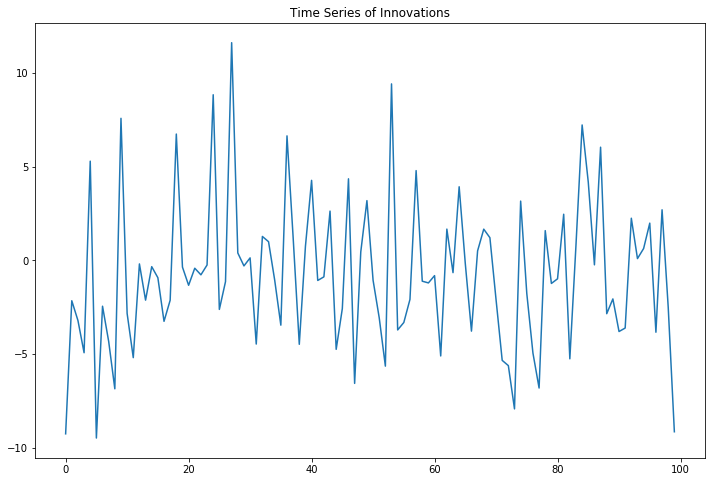

In [129]:
plt.plot(innov)
plt.title("Time Series of Innovations")

Text(0.5, 1.0, 'Histogram of Innovation')

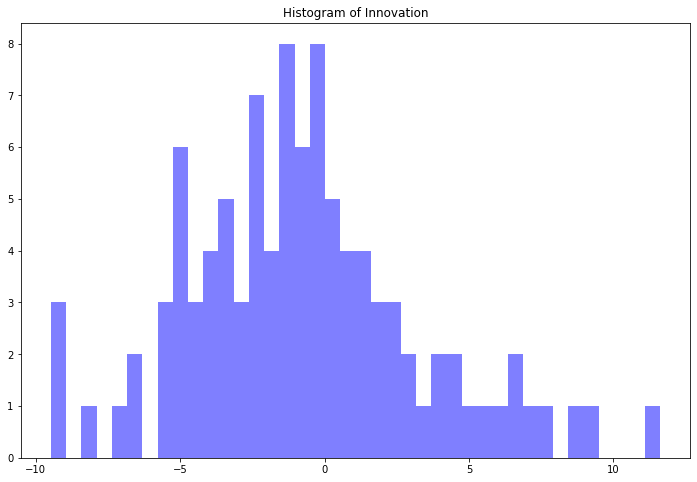

In [128]:
plt.hist(innov, 40, facecolor='blue', alpha=0.5)
plt.title("Histogram of Innovations")

In [166]:
# check autocorrelation
fig = plt.figure()
plt.plot(auto(innov[:,0]), label='autocorrelation')
plt.title("Autocorrelation of the Innovation")
plt.legend()
plt.show()